Notebook to replicate our results for data set 3 which uses a RNN for condition procession

In [1]:
import copy
import torch.nn as nn
import torch
from FrEIA.framework import *
from FrEIA.modules import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = torch.device("cuda:0")
pad = lambda x: nn.utils.rnn.pad_sequence(x, batch_first = True)
pack = lambda x, y: nn.utils.rnn.pack_padded_sequence(x, y, batch_first=True, enforce_sorted=False)

In [2]:
def load_data():
    """
    Helper function to read the data which is saved in multiple .csv files
    converts data to pytorch tensors
    """
    all_data = []
    all_params = []
    all_length = []
    i = 0
    j = 0
    while(True):
        name_dat = f"./data_masks{j}/dat{i}.csv"
        name_param = f"./params_masks{j}/params{i}.csv"
        try:
            df_dat = pd.read_csv(name_dat)
            df_param = pd.read_csv(name_param)
            param = df_param.to_numpy()[0,[0,1,10]]
            data = df_dat.iloc[:,2].to_numpy().reshape(-1,7)[:,[0,1,2,3]]
            if len(data[np.isnan(data)]) == 0:
                all_data.append(torch.from_numpy(data).to(torch.float32).to(device))
                all_params.append(param)
                all_length.append(len(data))
            else:
                print(i)
            i += 1
        except Exception as e:
            i = 0
            j += 1
            print("Loaded",len(all_data),"Entries")
        if j>8:
            print("not so much data")
            break
        if len(all_data)%1000 == 0:
            print("Loaded",len(all_data),"Entries")
    all_params = torch.from_numpy(np.array(all_params)).to(torch.float32).to(device)
    return all_data, all_params, all_length

data, params, length = load_data()
data_dict = {"data": data,
            "params": params,
            "length": length}

torch.save(data_dict, "data_third.save")

'\n# save the data in a torch file which is much faster to load then the .csvs\n\ndata, params, length = load_data()\ndata_dict = {"data": data,\n            "params": params,\n            "length": length}\n\ntorch.save(data_dict, "data_third.save")\n'

In [3]:
#data_dict = torch.load("data_third.save", map_location = device)

In [4]:
padded_data = pad(data_dict["data"][:260000])
params = data_dict["params"][:260000]
length = data_dict["length"][:260000]
test_dat = data_dict["data"][260000:]
test_params = data_dict["params"][260000:]
test_length = data_dict["length"][260000:]

In [5]:
class preprocessor():
    """
    Used to save initial means and range of the parameters and
    applies the preprocessing
    
    """
    def __init__(self, params):
        self.means = params.mean(dim = 0)
        self.max = torch.abs(params-self.means).max(dim = 0)[0]+1e-5
 
    def __call__(self, params, fwd = True):
        #return params
        if fwd:
            return torch.arctanh((params - self.means)/self.max)
        else:
            return torch.tanh(params) * self.max + self.means

prepper = preprocessor(params)
prepped = prepper(params, fwd = True)

In [6]:
class Decoder(nn.Module):
    """
    Decoder base class for use in an autoencoder
    N: amount of linear layers
    hidden_size: width of the hidden layers
    out_size: output dim of the decoder, should match the rnns input dim
    lr: learning rate
    """
    def __init__(self, N, inp_size, hidden_size, out_size, lr = 1e-3):
        super(Decoder, self).__init__()
        self.inp_size = inp_size
        self.linear = get_linear_subnet(N, inp_size, hidden_size, out_size)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.linear.parameters())) 
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of Decoder parameters: {n_trainable}", flush=True)        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.999],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )        
        
    def forward(self, x):
        return self.linear(x)

class AE():
    """
    Autoencoder class used to pretrain the RNN
    as decoder a simple fcnn is used
    rnn: object of type RNN which is trained
    N: amount of linear layers for the decoder
    hidden_size: width of the hidden decoder layers
    dim: output dim of the decoder, should match the rnns input dim
    """
    def __init__(self, rnn, N = 6, hidden_size = 256, dim = 4):
        self.dim = dim
        self.encoder = rnn
        self.decoder = Decoder(N, rnn.get_dim(), hidden_size, 149 * self.dim)
    def train(self, epochs, x, lengths, batch_size = 2048):
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros((batch_size,149,self.dim), dtype = torch.float32, device = device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(x))
            epoch_losses = 0
            for i in range(len(x)//batch_size):
                xsamps = x[epoch_index][i*batch_size:(i+1)*batch_size]
                length = lengths[epoch_index][i*batch_size:(i+1)*batch_size]
                
                packed_xsamps = pack(xsamps, length)
                
                self.decoder.optimizer.zero_grad(set_to_none=True)
                self.encoder.optimizer.zero_grad(set_to_none=True)
                encoded = self.encoder(packed_xsamps)
                decoded = self.decoder(encoded).view(-1,149,self.dim)
                difference = (torch.where(xsamps != 0, decoded, zeros)-xsamps)**2
                loss = torch.mean(difference)
                if loss < 1e30:
                    loss.backward()
                else:
                    print(f"loss is {loss}")
                    return
                self.encoder.optimizer.step()
                self.decoder.optimizer.step()
                epoch_losses += loss.item()/(len(x)//batch_size)
            loss_curve.append(epoch_losses)
            self.encoder.scheduler.step(epoch_losses)
            self.decoder.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
        self.decoder.optimizer.zero_grad(set_to_none=True)
        self.encoder.optimizer.zero_grad(set_to_none=True)
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve))      
        
    def inference(self, x):
        with torch.no_grad():
            decoded = self.decoder(self.encoder(x.view(1,-1,self.dim))).view(149,self.dim).cpu().numpy()
        xnump = x.cpu().numpy()
        fig, ax = plt.subplots(4, figsize = (8,8))
        names = ["Susceptible", "Infected", "Immune", "Dead", "Asymptomatic", "Hospitalized", "Severe"]
        for i in range(4):
            ax[i].plot(np.arange(len(xnump)), xnump[:,i], label = f"Truth")
            ax[i].plot(np.arange(149), decoded[:,i], label = f"Fake")
            ax[i].set_ylabel(names[i])
            
            ax[i].legend()
            ax[i].set_ylim([0,1])
        ax[3].set_xlabel("Time in days")
        plt.savefig("rnn.pdf")

In [7]:
def get_linear_subnet(N, inp_size, hidden_size, out_size):
    """
    Helper function to get linear network with ReLU activation
    N: amount of layers, not including the final linear output layer
    inp_size: dimension of the input
    hidden_size: width of the N-1 hidden layers
    out_size: dimension of the output
    """
    layer_list = []
    layer_list.append(nn.Linear(inp_size, hidden_size))
    layer_list.append(nn.ReLU())
    for i in range(N-1):
        layer_list.append(nn.Linear(hidden_size, hidden_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(hidden_size, out_size))
    return nn.Sequential(*layer_list).to(device)

class RNN(nn.Module):
    """"
    RNN baseclass, used as conditioning network for the cINN. Implemented as an LSTM
    inp_size: dimension of the input timeseries
    hidden_size: parallel channels used by the rnns
    numm_rnns: amount of lstms
    lr: learning rate
    bi: wether to use bidirectional lstms or not
    """
    def __init__(self, inp_size, hidden_size = 5, num_rnns = 6, lr = 1e-3, bi = False):
        super(RNN, self).__init__()
        self.inp_size = inp_size
        self.rnn = nn.LSTM(inp_size, hidden_size, num_rnns, batch_first = True, bidirectional = bi).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.rnn.parameters())) 
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of RNN parameters: {n_trainable}", flush=True)        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )        
        
    def forward(self, x):
        full, (last, cn) = self.rnn(x)
        return torch.swapaxes(last, 0, 1).reshape(last.shape[1], -1)
    
    def get_dim(self):
        """
        passes dummy variable through network to get the outputs shape
        """
        return self.forward(torch.randn(1,100,self.inp_size, device = device)).shape[1]
        
    
class cINN(nn.Module):
    """
    cINN baseclass, using cubic spline blocks.
    inp_size: dimension of the input
    cond_size: dimension of the conditions
    num_blocks: amount of coupling blocks used
    sub_layers: amount of linear layers in the subnetworks
    sub_width: width of the subnetworks
    lr: learning rate, scheduler used is reduce_on_plateau
    """
    def __init__(self, inp_size, cond_size, num_blocks = 10, sub_layers = 3, sub_width = 256, lr = 2e-4):
        super(cINN, self).__init__()
        constructor_fct = lambda x_in, x_out: get_linear_subnet(sub_layers, 
                                                                x_in,
                                                                x_in,
                                                                x_out)

        block_kwargs = {
                        "num_bins": 120,
                        "subnet_constructor": constructor_fct,
                        "bounds_init": 5,
                        "permute_soft": False
                           }
        inp_size = (inp_size,)        
        nodes = [InputNode(*inp_size, name='inp')]
        cond_node = ConditionNode(*(cond_size,))
        for i in range(num_blocks):
            nodes.append(Node(
                    [nodes[-1].out0],
                    CubicSplineBlock,
                    block_kwargs,
                    conditions = cond_node,
                    name = f"block_{i}",
                ))
        nodes.append(OutputNode([nodes[-1].out0], name='out'))
        nodes.append(cond_node)
        self.model = GraphINN(nodes, verbose=False).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.model.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of cINN parameters: {n_trainable}", flush=True)
        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )
    def forward(self, x, cond = None, rev = False):
        return self.model(x, c = cond, rev = rev)


class Estimator():
    """
    Wrapper for training cINN and RNN at the same time, also used for inference
    """
    def __init__(self, rnn, cinn):
        self.cinn = cinn
        self.rnn = rnn

    def metrik(self, true, data, zeros):
        """
        Used to measure the distance between truth and generated parameters
        Better interpretable than the Loss function
        """
        with torch.no_grad():
            cond = self.rnn(data)
            output, _ = self.cinn(zeros, cond, rev = True)
            output = torch.abs(prepper(output, fwd = False) - prepper(true, fwd = False))
            output = torch.mean(output, dim = 0).cpu().numpy()
        print("Metric:", output)
        return output
    
    def train(self, epochs, xtrain, ytrain, lengths, batch_size, train_rnn = True):
        """
        Trains the cINN and shows loss and metric plots
        epochs: amount of epochs to train
        xtrain: training parameters
        ytrain: corresponding time series, need to be zero padded
        lengths: real lengths of the time series, used for packing them again
        batch_size: Batch size used for the training
        train_rnn: Enable weight updates for the RNN
        """
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros(batch_size,3).to(device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(xtrain))
            epoch_losses = 0
            for i in range(len(xtrain)//batch_size):
                ysamps = ytrain[epoch_index][i*batch_size:(i+1)*batch_size]
                xsamps = xtrain[epoch_index][i*batch_size:(i+1)*batch_size]
                length = lengths[epoch_index][i*batch_size:(i+1)*batch_size]
                
                packed_ysamps = pack(ysamps, length)
                
                self.cinn.optimizer.zero_grad(set_to_none=True)
                if train_rnn:
                    self.rnn.optimizer.zero_grad(set_to_none=True)
                
                cond = self.rnn(packed_ysamps)

                gauss, jac = self.cinn(xsamps, cond)
                loss = torch.mean(gauss**2/2) - torch.mean(jac)/gauss.shape[1]
                    
                loss.backward()
                self.cinn.optimizer.step()
                self.rnn.optimizer.step()
                epoch_losses += loss.item()/(len(xtrain)//batch_size)
            loss_curve.append(epoch_losses)
            
            self.cinn.scheduler.step(epoch_losses)
            if train_rnn:
                self.rnn.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
            metrics_curve.append(self.metrik(xsamps,packed_ysamps, zeros))
        self.cinn.optimizer.zero_grad(set_to_none=True)
        if train_rnn:
            self.rnn.optimizer.zero_grad(set_to_none=True)
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve), label = "Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()
        metrics_curve = np.array(metrics_curve)
        for i in range(metrics_curve.shape[1]):
            plt.plot(np.arange(len(loss_curve)), metrics_curve[:,i], label = f"Metric $x_{i}$")
        plt.xlabel("Epoch")
        plt.ylabel("Metric")
        
    def inference(self, data_point, true_param):
        """
        Predicts a parameter distribution for given time series
        Overlays the true parameter to see how well the network performs
        """
        outputs = []
        with torch.no_grad():
            for i in range(100):
                gauss = torch.randn(1000,3).to(device)
                cond = self.rnn(data_point.repeat(1000,1,1).to(device))
                output, _ = self.cinn(gauss, cond, rev = True)
                outputs.append(output)
        output = torch.cat(outputs, dim = 0)
        output = prepper(output, fwd = False).detach().cpu()
        names = ["Initial infected", "Initial immune", "Mask percentage"]
        fig, axis = plt.subplots(2,2, figsize = (10,10))
        for i in range(len(names)):
            ax = axis[int((i-i%2)/2),i%2]
            ax.hist(output.numpy()[:,i], bins = 100, density = True, label = "Generated")
            ax.axvline(true_param[i], color = "r", label = "Truth")
            ax.set_xlabel(names[i], fontsize = 12)
            ax.legend()
            if i%2 == 0:
                ax.set_ylabel("Normalized", fontsize = 12)

        hist, xedges, yedges = np.histogram2d(output.numpy()[:,0], output.numpy()[:,2], bins=[100,100], density=True)
        
        plt.pcolormesh(xedges, yedges, hist.T, rasterized=True)
        plt.xlabel("Initial infected")
        plt.ylabel("Mask percentage")
        cb = plt.colorbar()

Number of RNN parameters: 960
Number of Decoder parameters: 488532
Epoch: 1
Loss: 0.02643129273155142
Epoch: 2
Loss: 0.0010890994301354067
Epoch: 3
Loss: 0.0007243595392783247
Epoch: 4
Loss: 0.0007441478766619212
Epoch: 5
Loss: 0.0007205502054328838
Epoch: 6
Loss: 0.0007153947820096082
Epoch: 7
Loss: 0.000720826841499065
Epoch: 8
Loss: 0.0007203296949488244
Epoch: 9
Loss: 0.0007178668890865371
Epoch: 10
Loss: 0.0007215312946336494


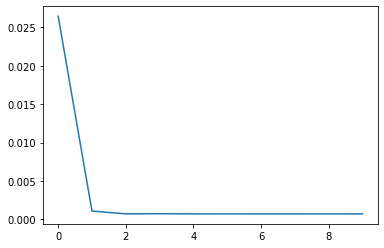

In [8]:
rnn = RNN(4, hidden_size = 4, num_rnns = 6, lr = 1e-3, bi = False)
ae = AE(rnn, dim = 4)
ae.train(10, padded_data, np.array(length))

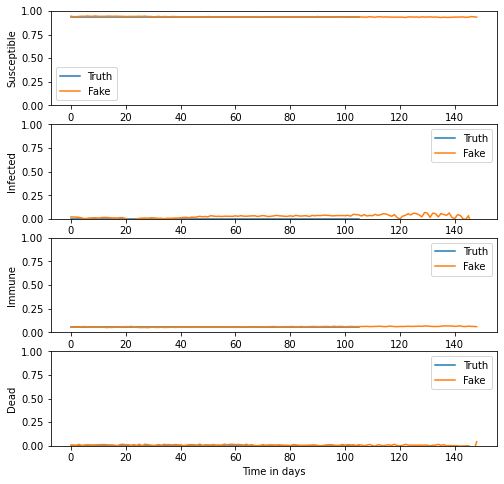

In [9]:
ae.inference(test_dat[np.random.randint(1000)])

Number of cINN parameters: 145340
Epoch: 1
Loss: 0.436256274817482
Metric: [0.00389778 0.02530443 0.07371403]
Epoch: 2
Loss: 0.28302657249427965
Metric: [0.0029674  0.02522859 0.07534811]
Epoch: 3
Loss: 0.20380994098054042
Metric: [0.00267556 0.02380667 0.07393046]
Epoch: 4
Loss: 0.17640718912321424
Metric: [0.00268663 0.02387364 0.06896715]
Epoch: 5
Loss: 0.12603843425001413
Metric: [0.00259934 0.02319514 0.0595229 ]
Epoch: 6
Loss: 0.06566433230089762
Metric: [0.00272289 0.0181812  0.06153452]
Epoch: 7
Loss: 0.06458904795230382
Metric: [0.00266737 0.02256179 0.05945274]
Epoch: 8
Loss: -0.025489524006843556
Metric: [0.00267024 0.01682863 0.05712584]
Epoch: 9
Loss: -0.12226802394503634
Metric: [0.00258754 0.01650624 0.05594491]
Epoch: 10
Loss: -0.032769769430160516
Metric: [0.00265949 0.01672303 0.05616516]


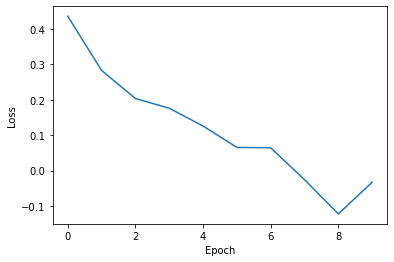

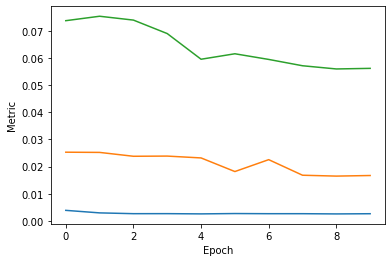

In [10]:
cinn = cINN(3, rnn.get_dim())
network = Estimator(rnn, cinn)
network.train(10, prepped, padded_data, np.array(length), batch_size = 2048, train_rnn = False)

Epoch: 1
Loss: -0.1568880189978887
Metric: [0.00261727 0.01541802 0.05665078]
Epoch: 2
Loss: -0.20145032921480752
Metric: [0.00263088 0.01540347 0.05638933]
Epoch: 3
Loss: -0.21749724518685112
Metric: [0.00258819 0.01554027 0.05632516]
Epoch: 4
Loss: -0.22757382525338068
Metric: [0.00261029 0.01567229 0.05620169]
Epoch: 5
Loss: -0.23788174277260188
Metric: [0.00262056 0.01555265 0.05541079]
Epoch: 6
Loss: -0.24575366978607474
Metric: [0.00262318 0.01559749 0.05776571]
Epoch: 7
Loss: -0.2495907847843473
Metric: [0.00263254 0.0156051  0.05823936]
Epoch: 8
Loss: -0.25136331409688983
Metric: [0.00265943 0.01524265 0.05565503]
Epoch: 9
Loss: -0.25340734303943707
Metric: [0.00263576 0.01510508 0.05577473]
Epoch: 10
Loss: -0.2541651285829998
Metric: [0.00265829 0.0156961  0.05554193]
Epoch: 11
Loss: -0.256781768940744
Metric: [0.0026736  0.01545233 0.05763313]
Epoch: 12
Loss: -0.2568991401838878
Metric: [0.00260221 0.01493448 0.05887399]
Epoch: 13
Loss: -0.2578784014497484
Metric: [0.00265087

Epoch: 103
Loss: -0.28227296566206306
Metric: [0.00265267 0.01586783 0.05555722]
Epoch: 104
Loss: -0.28276248299886303
Metric: [0.002558   0.01476182 0.05777774]
Epoch: 105
Loss: -0.2827279697808007
Metric: [0.00265726 0.01608652 0.05535086]
Epoch: 106
Loss: -0.28285878092523603
Metric: [0.00255932 0.01589762 0.05625376]
Epoch: 107
Loss: -0.2828216673362822
Metric: [0.00259234 0.01524223 0.05562083]
Epoch: 108
Loss: -0.28269539111190367
Metric: [0.00256572 0.01490603 0.05734394]
Epoch: 109
Loss: -0.28315266493767016
Metric: [0.0025757  0.0151938  0.05672029]
Epoch: 110
Loss: -0.2831708514501179
Metric: [0.00260874 0.01536398 0.05618917]
Epoch: 111
Loss: -0.2830430966994118
Metric: [0.00265793 0.01572621 0.05546152]
Epoch: 112
Loss: -0.2831505019040334
Metric: [0.00253857 0.01527542 0.05424313]
Epoch: 113
Loss: -0.28356521635774584
Metric: [0.00260827 0.01572247 0.05542853]
Epoch: 114
Loss: -0.28277340389433364
Metric: [0.00258916 0.01491482 0.05476375]
Epoch: 115
Loss: -0.2834092038018

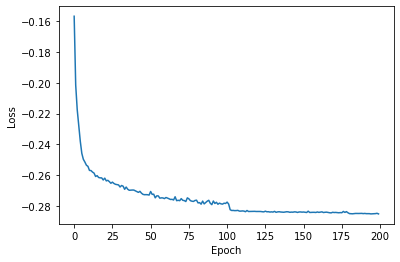

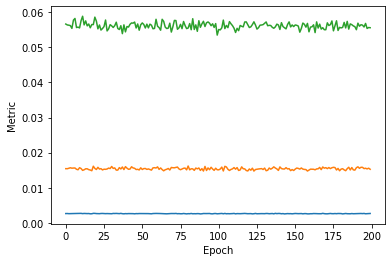

In [11]:
network.train(200, prepped, padded_data, np.array(length), batch_size = 2048, train_rnn = True)

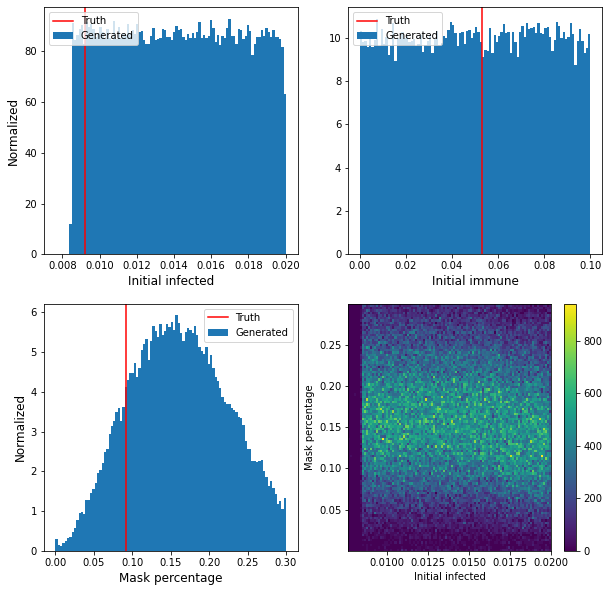

In [12]:
i = np.random.randint(len(test_dat))
network.inference(test_dat[i], test_params[i])